In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)   
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")
        
def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook
    
    # ignore a useless LGBM warning
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")

_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings

working dir is 'C:\Projects\facet\facet'
added `C:\Projects\facet\pytools\src` to python paths
added `C:\Projects\facet\facet\src` to python paths
added `C:\Projects\facet\sklearndf\src` to python paths


In [2]:
# Standard imports
import numpy as np
import pandas as pd
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import shap

# facet imports - WORKS
from facet import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.viz import SimulationDrawer

# sklearndf imports - WORKS
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import (
    GradientBoostingClassifierDF,
    RandomForestClassifierDF,
    LinearDiscriminantAnalysisDF,
    LogisticRegressionDF,
    LinearSVCDF
)
from sklearndf.classification.extra import LGBMClassifierDF
from sklearndf.transformation import (
    ColumnTransformerDF,
    OneHotEncoderDF,
    SimpleImputerDF,
)
from sklearndf.transformation.extra import BorutaDF

# pytools - WORKS
from pytools.viz.dendrogram import DendrogramDrawer, LinkageTree
from pytools.viz.matrix import MatrixDrawer
from pytools.data.simulation import sim_data

In [3]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _configure_matplotlib():
    # set global options for matplotlib
    
    import matplotlib
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
    matplotlib.rcParams['figure.dpi'] = 72

_configure_matplotlib()

del _configure_matplotlib

# Background

**Facet** is a package built to provide the following for supervised learning:

1. Creating a structured reproducible pipeline that spans pre-processing through to model inspection and simulation
2. Cross-validation for learner selection using resampling methods (bootstrap)
3. Advanced SHAP analysis capabilities to assess the joint behaviour of features on model predictions
4. Univariate simulation for understanding feature impact and potential optimal values

This example using simulated data for supervised classification will focus mainly on 2, 3 and 4.

**Bootstrap CV for learner selection**

Bootstrap CV is an internal validation method that involves repeatedly sampling from the original data to create data used to train learners. For each resample, the data not sampled is used as a test set. This allows a greater variety of training sets to be generated from the original data to assess average learner performance and the associated variability in performance. The bootstrap CV generates a crossfit object with all the resampled training and test data, as well as model fits. This supports the generation of SHAP values simulation.

**Model inspection using SHAP**

The SHAP approach <http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions> has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for a given observation. SHAP values are computed for every feature and observation.

The Facet LearnerInspector computes these SHAP values for each bootstrap resample using the best model identified by the LearnerRanker. The Facet LearnerInspector then provides advanced model inspection through new SHAP-based summary metrics for understanding feature redundancy and synergy.

Briefly, the definitions are as follows:

1. **Redundancy** represents how much information is shared between two features contributions to model predictions. In our example we might expect redundancy between BMI and waist circumference as a higher BMI will tend to lead to a larger waist circumference and vice versa. This means just knowing one or the other is likely to provide similar predictive performance.

2. **Synergy** represents how much the combined information of two features contributes to the model predictions. In our example we could hypothesize that knowing both gender and BMI provides greater accuracy in predicting prediabetes risk than either alone.

SHAP values from the LearnerInspector can also be used with the SHAP package plotting functions for sample and observation level SHAP visualizations, such as SHAP distribution plots, dependency plots, force plots and waterfall plots.

**Univariate simulation**

Using the crossfit, we can simulate feature values and look at the impact of the probability of the outcome to assess both the pattern of association, as well as if there are any optimal values.

# Simulating classification data

For this tutorial we use simulated data, so we can control the following:

1. creating features that do not directly predict the outcome but are strongly related to another feature that does which creates redundancy
2. creating features that have an impact on the predictions in combination which creates synergy

Furthermore, the simulated data is complete and numeric so no imputation or one-hot encoding is required, and the data also contains features involved in predicting the outcome except for those that are redundant. For these reasons we will not cover Boruta for pre-learner feature elimination, or creating adding a pre-processing pipeline to the Facet pipeline.

In [4]:
# Simulate data
sim_df = sim_data(intercept=-9,
                  n=500,
                  linear_vars=1,
                  linear_var_coef=[4],
                  surg_err=0.1,
                  bin_var_p=0.1,
                  bin_coef=6)
sim_df.head()

,TwoFactor1,TwoFactor2,Linear1,Nonlinear1,Nonlinear2,Nonlinear3,Linear1_prime,Binary1,Binary1_prime,target
0,-0.581241,1.026704,0.812965,0.182246,0.314480,0.115185,0.840675,1,0,1
1,-1.210667,0.897840,0.875094,-0.644456,0.327105,0.381858,0.804399,1,0,1
2,-0.165506,-1.051360,-2.943134,-0.522322,0.043432,0.690618,-2.881194,1,0,0
3,-0.792684,-0.904317,-0.385633,-0.337371,0.844025,0.929162,-0.518288,1,0,0
4,0.016842,-0.515999,1.464418,0.145913,0.525285,0.249259,1.703776,0,1,0


In [5]:
sim_df.describe().T

,count,mean,std,min,25%,50%,75%,max
TwoFactor1,500.0,-0.069625,1.438791,-3.885606,-1.012909,-0.158775,0.868302,5.602706
TwoFactor2,500.0,-0.001348,1.430010,-4.290577,-1.008645,0.025593,0.949979,4.239929
Linear1,500.0,0.034931,1.045131,-2.943134,-0.609850,0.038398,0.775525,2.838299
Nonlinear1,500.0,0.009576,0.559522,-0.998753,-0.478448,0.020621,0.483242,0.995503
Nonlinear2,500.0,0.493800,0.303512,0.000836,0.211483,0.522541,0.734629,0.999510
Nonlinear3,500.0,0.506346,0.289745,0.000791,0.250444,0.493982,0.760510,0.999559
Linear1_prime,500.0,0.028444,1.046325,-2.881194,-0.592488,0.034784,0.804658,2.817386
Binary1,500.0,0.902000,0.297612,0.000000,1.000000,1.000000,1.000000,1.000000
Binary1_prime,500.0,0.098000,0.297612,0.000000,0.000000,0.000000,0.000000,1.000000
target,500.0,0.564000,0.496384,0.000000,0.000000,1.000000,1.000000,1.000000


# Instigating a basic learner pipeline

Facet implements Bootstrap CV which uses resampling to create a training set. This re-sampling procedure is repeated many times to get an estimate of average model performance and the variability of that performance. This is an important extension of the native scikit-learn cross-validators which do not support sampling with replacement.

To see a list of hyper-parameters you can use `classifier_name().get_params().keys()` where classifier_name is, for example, `RandomForestClassifierDF`. Use `classifier_name().get_params()` to see the default values. 

Finally, for this exercise we will use accuracy (the default) as the performance metric for scoring and ranking our learner. 

First we create the Sample object that is needed for the Facet pipeline.

In [6]:
# set sample
sims=Sample(
    observations=sim_df,
    features=sim_df.columns[:-1],
    target='target'
)

Next we define our learner pipeline. Note if a pre-processing pipeline has been created this can be included in `ClassifierPipelineDF()` by using `preprocessing=pipeline_name` argument. `LearnerGrid` is used to wrap a classifier pipeline with hyper-parameters for tuning. If you wish to create a pipeline for a second classifier, you need to define a `ClassifierPipelineDF()` and `LearnerGrid()` for it.

In [7]:
# Create classifier and generate SHAP values from crossfit
clf_pipeline=ClassifierPipelineDF(
    classifier=RandomForestClassifierDF(random_state=42)
)
clf_grid=LearnerGrid(
    pipeline=clf_pipeline,
    learner_parameters={'max_leaf_nodes': [5, 10, 20],
                       'n_estimators': [50, 100, 200]}
)

Now we create a bootstrapCV iterator the same way you create a cross-validation iterator with sklearn. Note if you wish to decrease or increase the number of resampled splits, use the n_splits argument.

In [8]:
cv_bs = BootstrapCV(random_state=42)

Next instigate and fit the `LearnerRanker()` which will apply the bootstrap CV and evaluate the performance of classifiers we opted to evaluate. To change the performance metric use the scoring argument in `LearnerRanker()` which can be any other sklearn metric applicable to the classifier(s) being used. A larger number of resampled splits, larger datasets, many classifiers and many hyper-parameters will be computationally intensive, and so may take some time to run. However, this can be parallelized.

In [9]:
# instigate ranker and fit
ranker = LearnerRanker(
    grids=[clf_grid],
    cv=cv_bs,
    n_jobs=-3,
).fit(sims)

Once the `LearnerRanker()` has finished running we can look at the summary output to see which model was scored best according to our ranking metric. Based on or bootstrap CV we have found that among the learner configurations we investigated that a Random Forest with a ranking score of 0.79. The ranking score is the average accuracy (0.84) minus 2x the standard deviation of the accuracy across the bootstrapCV (2 x 0.02). This is to take into account both the average performance and variability when selecting a learner.

In [10]:
# Let's look at performance
print(ranker.summary_report())

Rank  1: RandomForestClassifierDF, ranking_score=    0.793, scores_mean=    0.837, scores_std=    0.022, parameters={classifier__max_leaf_nodes=20,classifier__n_estimators=50}

Rank  2: RandomForestClassifierDF, ranking_score=    0.793, scores_mean=    0.836, scores_std=   0.0217, parameters={classifier__max_leaf_nodes=20,classifier__n_estimators=100}

Rank  3: RandomForestClassifierDF, ranking_score=    0.792, scores_mean=    0.836, scores_std=   0.0224, parameters={classifier__max_leaf_nodes=20,classifier__n_estimators=200}

Rank  4: RandomForestClassifierDF, ranking_score=    0.776, scores_mean=    0.824, scores_std=   0.0236, parameters={classifier__max_leaf_nodes=10,classifier__n_estimators=200}

Rank  5: RandomForestClassifierDF, ranking_score=    0.775, scores_mean=    0.822, scores_std=   0.0235, parameters={classifier__max_leaf_nodes=10,classifier__n_estimators=100}

Rank  6: RandomForestClassifierDF, ranking_score=    0.775, scores_mean=    0.823, scores_std=   0.0243, parame

To see the full specification of the best ranker classifier we can look into `.best_model.classifier` from the ranker.

In [11]:
ranker.best_model.classifier

RandomForestClassifierDF(bootstrap=True, ccp_alpha=0.0, criterion='gini',
                         max_depth=None, max_features='auto', max_leaf_nodes=20,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=50, n_jobs=None, oob_score=False,
                         random_state=42, verbose=0, warm_start=False)

With a best model identified using `BootstrapCV` and our `LearnerRanker`, we can now apply the inspector, which will apply the SHAP approach to model inspection, including the advanced approach provided by Facet. This will reuse the best model applied to each resampled split to generate a SHAP value matrix for each one. For this reason it can take some time to run, so again parallelization is possible and we can modify the number of splits to run on by using the `resize` property of the `ranker.best_model_crossfit` object. Here we have used just 20 out of the possible 100.

In [12]:
# run inspector
inspector = LearnerInspector(
    n_jobs=-3,
    verbose=10,
).fit(
    crossfit=ranker.best_model_crossfit.resize(20)
)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-3)]: Done  12 out of  20 | elapsed:    5.4s remaining:    3.6s
[Parallel(n_jobs=-3)]: Done  15 out of  20 | elapsed:    5.9s remaining:    1.9s
[Parallel(n_jobs=-3)]: Done  18 out of  20 | elapsed:    6.0s remaining:    0.6s
[Parallel(n_jobs=-3)]: Done  20 out of  20 | elapsed:    6.1s finished


With the inspector run, we can now access things like feature importance and the advanced SHAP capabilities of Facet such as synergy and redundancy.

In [13]:
# obtain Facet feature importance, and synergy and redundancy matrices
f_importance = inspector.feature_importance()
redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()

We can also generate a standard SHAP value matrix and a training dataset to use with the visulizations of the standard shap library.

In [14]:
# Also let's get some info for standard SHAP plots!
shap_values = inspector.shap_values().to_numpy()
X_train = sims.features.reset_index()[sims.features.columns]

# Using the inspector and SHAP to understand model predictions

## Feature importance

Using the Facet implementation based on the LearnerInspector. Each feature is ranked according to the mean SHAP value for that feature. This plot can also be paired with a standard SHAP distribution plot for features to see if there is any directional tendency for the associations.

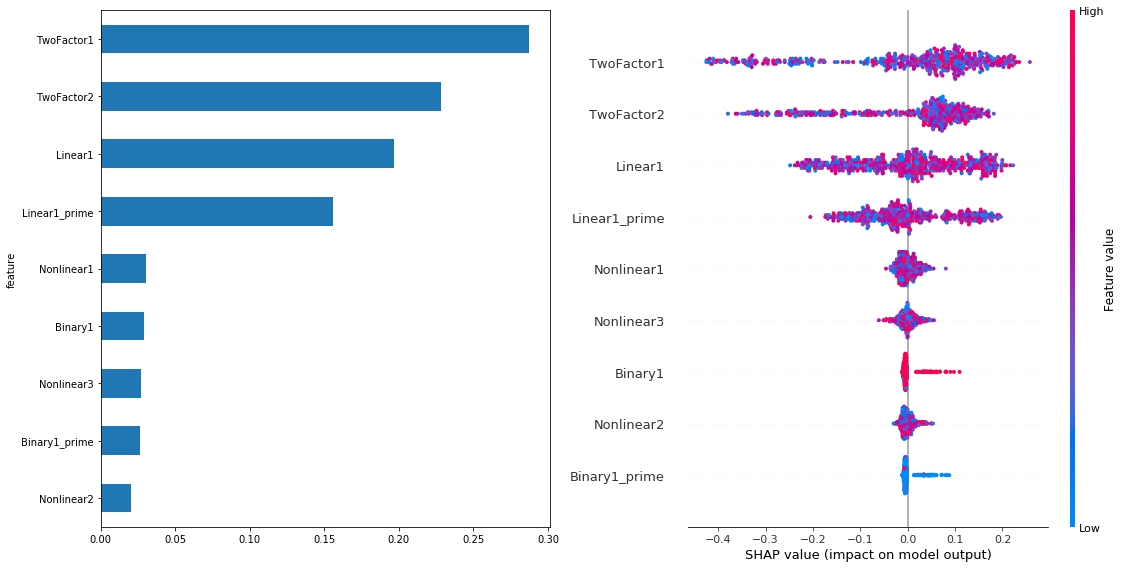

In [15]:
# Model overview: feature importance, SHAP summary, redundancy and synergy
# Facet feature importance
plt.subplot(1, 2, 1)
f_importance.sort_values().plot.barh()

# Standard summary plot
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, X_train, show=False, plot_size=(16.0, 8.0))
plt.tight_layout()

# Note: Standard SHAP feature importance output - not quite the same as Facet! Can be generated with the following code:
# shap.summary_plot(shap_values, X_train, plot_type='bar')

Based on the feature importances we can see that the most important features are TwoFactor1, TwoFactor2, Linear1 and Linear1_prime. We can also see that with regards to feature importance the model is assigning similar importance to Linear1 and Linear1_prime, and for Binary1 and Binary1_prime. Inspection of the SHAP value distributions does not provide any indication of a general direction of association for the features.

## Redundancy and synergy

Redundancy and synergy are part of the key extensions Facet makes to using SHAP values to understand model predictions. Redundancy represents the shared information between two features and synergy represents the degree to which one feature combines with another to generate a prediction.

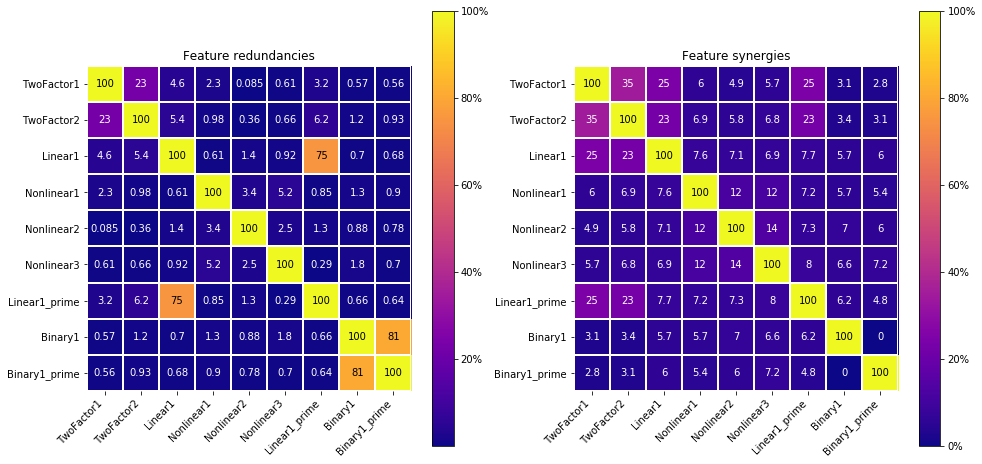

In [16]:
# redundancy and synergy heatmaps
plt.subplot(1, 2, 1)
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Feature redundancies")
plt.subplot(1, 2, 2)
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Feature synergies")

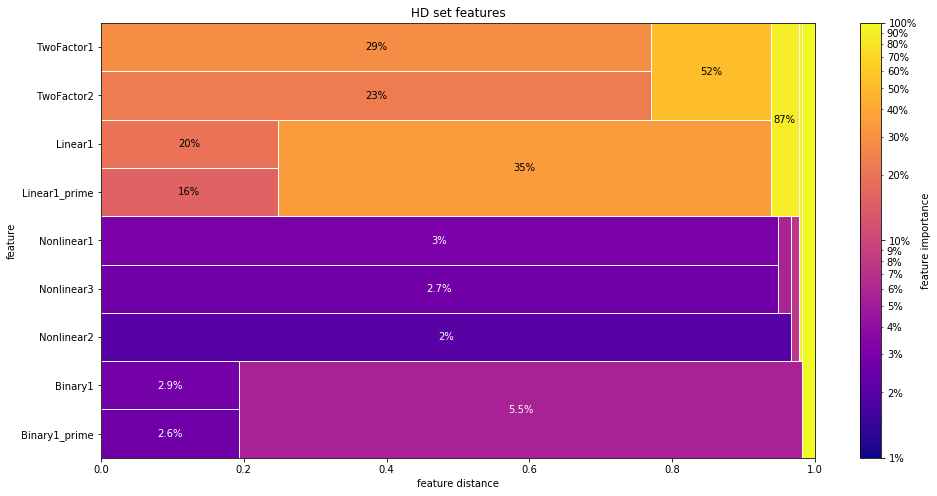

In [17]:
# can also do the dendograms as well
dd_redundancy = inspector.feature_redundancy_linkage()

# redundancy
DendrogramDrawer().draw(title="HD set features", data=dd_redundancy)

What might we infer from the above information?

1. For redundancy we can see two very clear clusters from both the matrix and the dendogram. As expected, our Linear1 and Linear1_prime features cluster together, as does Binary1 and Binary1_prime. Given the way we simulated the data it makes sense that these clusters of redundant features would be identified.

2. We see the highest degree of synergy in the matrix occur for TwoFactor1 and TwoFactor2. This matches our expectations as we included an interaction between these two features when we simulated the data. Interestingly, the moderate degree of synergy would suggest that relative to the independent contributions of each feature the interaction is not overly strong.

## Eliminating redundant features

Now the interesting thing is while this data is simulated and we know which features are redundant, it is clear from the feature importances the model has a hard time telling them apart. The redundnacy matric also confirms this, where we see that the paired redundant features have a noticeably high redundancy of around 70%-80%. Furthermore, we can see from the dendogram even more clearly that the redundant features cluster very early. So we should endeavour to eliminate redundant features.

First we create a new Facet sample object where we drop the features we have identified as redundant.

In [18]:
simssub = sims.drop(['Binary1_prime', 'Linear1_prime'])

Next we refit the `LearnerRanker()`

In [19]:
# instigate ranker and fit
ranker = LearnerRanker(
    grids=[clf_grid],
    cv=BootstrapCV(random_state=42),
    n_jobs=-3
).fit(simssub)

Look at the performance

In [20]:
# Let's look at performance
print(ranker.summary_report())

Rank  1: RandomForestClassifierDF, ranking_score=    0.788, scores_mean=    0.834, scores_std=   0.0234, parameters={classifier__max_leaf_nodes=20,classifier__n_estimators=50}

Rank  2: RandomForestClassifierDF, ranking_score=    0.785, scores_mean=    0.834, scores_std=   0.0241, parameters={classifier__max_leaf_nodes=20,classifier__n_estimators=100}

Rank  3: RandomForestClassifierDF, ranking_score=    0.782, scores_mean=    0.833, scores_std=   0.0256, parameters={classifier__max_leaf_nodes=20,classifier__n_estimators=200}

Rank  4: RandomForestClassifierDF, ranking_score=    0.769, scores_mean=    0.822, scores_std=   0.0264, parameters={classifier__max_leaf_nodes=10,classifier__n_estimators=200}

Rank  5: RandomForestClassifierDF, ranking_score=    0.768, scores_mean=    0.821, scores_std=   0.0264, parameters={classifier__max_leaf_nodes=10,classifier__n_estimators=50}

Rank  6: RandomForestClassifierDF, ranking_score=    0.768, scores_mean=    0.821, scores_std=   0.0267, paramet

Re-run the inspector

In [21]:
# run inspector
inspector = LearnerInspector(
    n_jobs=-3,
    verbose=10,
).fit(
    crossfit=ranker.best_model_crossfit.resize(20)
)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-3)]: Done  12 out of  20 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-3)]: Done  15 out of  20 | elapsed:    1.8s remaining:    0.5s
[Parallel(n_jobs=-3)]: Done  18 out of  20 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=-3)]: Done  20 out of  20 | elapsed:    2.2s finished


Obtain the key SHAP outputs as before

In [22]:
# obtain Facet feature importance, and synergy and redundancy matrices
f_importance = inspector.feature_importance()
redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()
dd_redundancy = inspector.feature_redundancy_linkage()

We also recreate the standard SHAP value matrix and training dataset

In [23]:
# Also let's get some info for standard SHAP plots!
shap_values = inspector.shap_values().to_numpy()
X_train = simssub.features.reset_index()[simssub.features.columns]

Now re-checking we can see that the is no longer any indication redundancy in the matrix and in the dendogram we observe that most of the features cluster very far to the right, indicating that there is little redundancy between the features in our model.

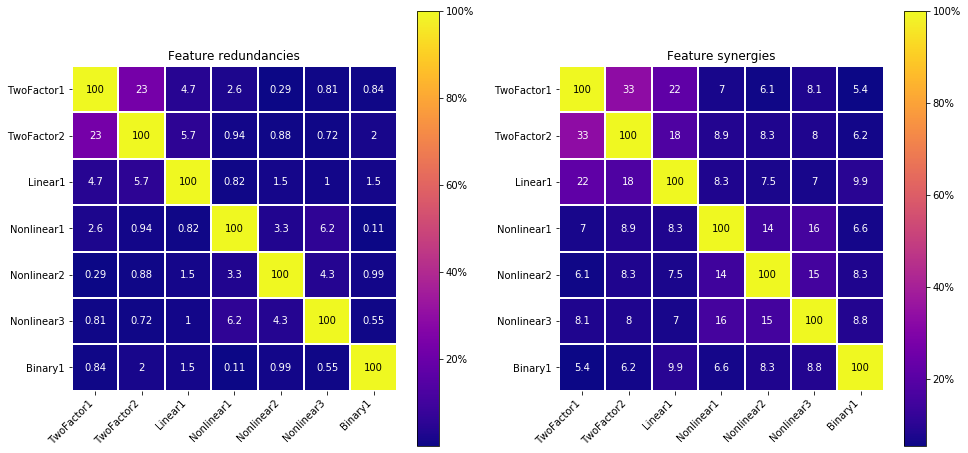

In [24]:
# redundancy and synergy heatmaps
plt.subplot(1, 2, 1)
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Feature redundancies")
plt.subplot(1, 2, 2)
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Feature synergies")

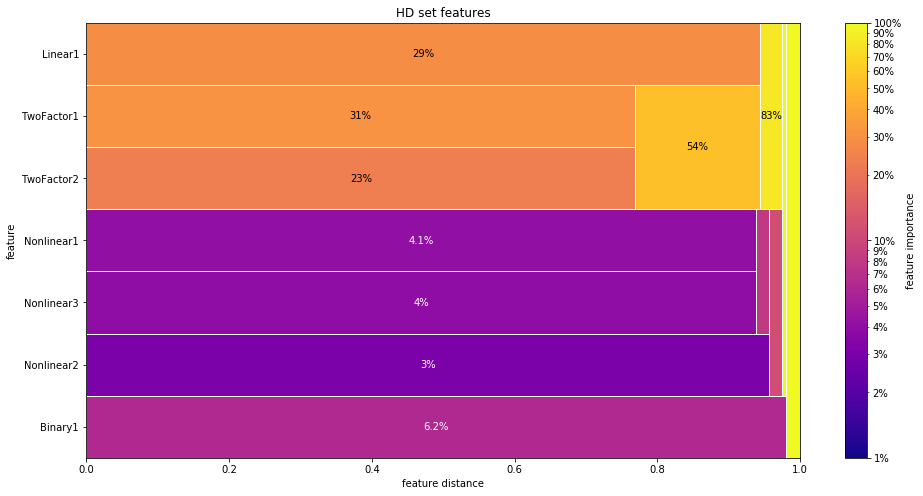

In [25]:
# redundancy dendogram
DendrogramDrawer().draw(title="HD set features", data=dd_redundancy)

## Other SHAP based visualizations

Note as shown above for the distribution of SHAP values by feature `shap.summary()` other shap library visualizations are also compatible with the SHAP values generated by Facet. For example, once we have removed redundant features we may wish to inspect the contributions of features to the prediction for a case where the outcome is likely and a case were the outcome is unlikely.

In the case of the low-likelihood case (force plot) we can see that Linear1 and TwoFactor2 are mainly driving the prediction lower.

In the case of the high-likelihood case (waterfall plot) TwoFactor2 is mainly responsible for driving the prediction higher.

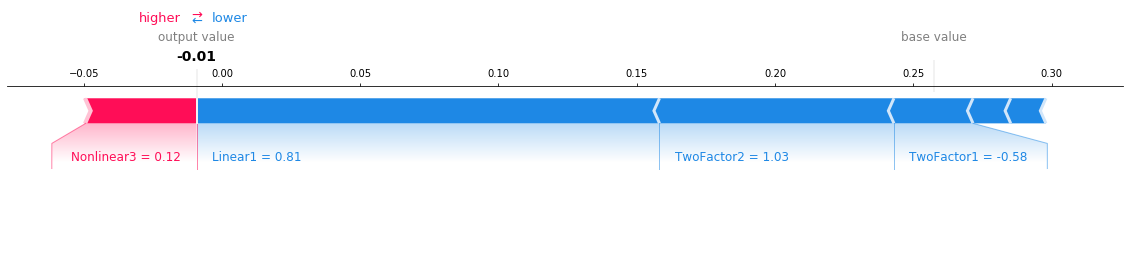

In [26]:
# Individual (local explanation) SHAP plots
base_value = np.log(simssub.target.mean()/(1-simssub.target.mean()))
shap.force_plot(base_value=base_value, shap_values=shap_values[0,:], features=X_train.iloc[0,:].round(2), matplotlib=True)

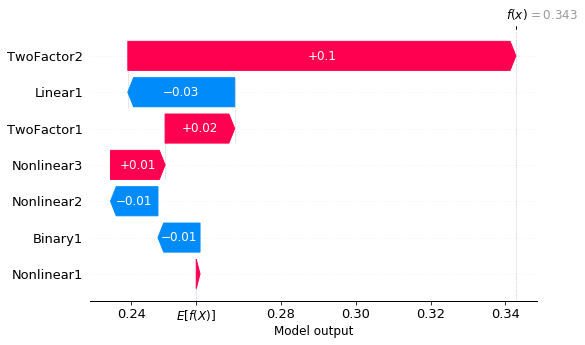

In [27]:
# The waterfall plot
shap.waterfall_plot(base_value, shap_values[234,:], feature_names=X_train.columns.values, max_display=10, show=True)

## Univariate simulation

Facet has the ability to quickly instigate and run univariate simulation. The idea is that the simulation will help us to understand what value of a feature might help to maximize or minimize the occurrence of an outcome.

First we select a feature to perform simulation with, and instigate the simulator and the partitioner.

In [28]:
sim_feature = "Linear1"
simulator = UnivariateUpliftSimulator(crossfit=ranker.best_model_crossfit, n_jobs=-1)
partitioner = ContinuousRangePartitioner()

Next we perform the simulation

In [29]:
univariate_simulation = simulator.simulate_feature(name=sim_feature, partitioner=partitioner)

Once run, we can view the results using `SimulationDrawer()`. As expect the Linear1 feature shows a linear association with the outcome, which is expected given the set-up of the simulation. Secondly we can see **TO COMPLETE ONCE FIXED**

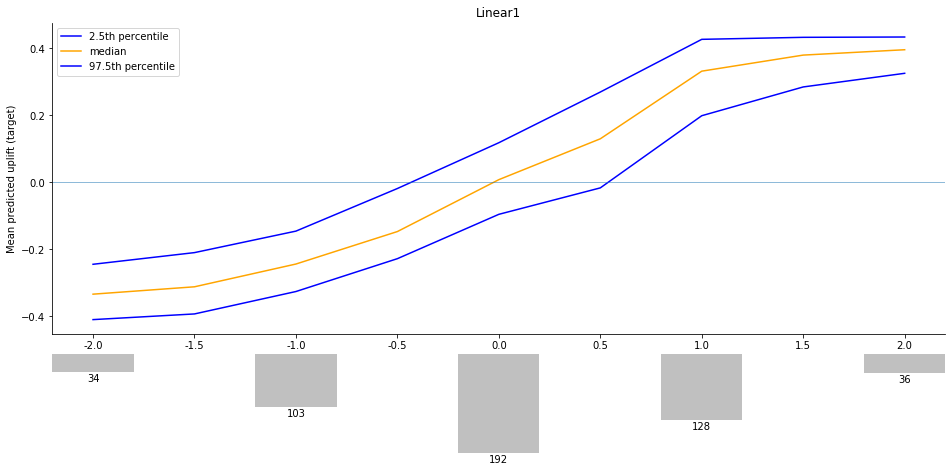

In [30]:
SimulationDrawer().draw(data=univariate_simulation, title=sim_feature)

Note we can use a text option to get values instead of a graph.

In [31]:
SimulationDrawer("text").draw(data=univariate_simulation, title=sim_feature)

SIMULATION REPORT: Linear1

Mean predicted uplift (target):

Partition  2.5th percentile  median     97.5th percentile
=========  ================  =========  =================
-2                -0.41      -0.334             -0.245   
-1.5              -0.393     -0.312             -0.21    
-1                -0.326     -0.244             -0.146   
-0.5              -0.228     -0.147             -0.0185  
0                 -0.0955     0.008              0.118   
0.5               -0.0166     0.13               0.27    
1                  0.199      0.332              0.427   
1.5                0.285      0.38               0.433   
2                  0.326      0.396              0.434   

Observed frequencies:

Partition  Frequency
=========  =========
-2                34
-1.5               0
-1               103
-0.5               0
0                192
0.5                0
1                128
1.5                0
2                 36



# Summary

In this short supervised classification tutorial using simulated data, we covered:

1. How to create a Facet pipeline for selecting a classifier.
2. How to use the advanced SHAP capabilities of Facet to refine the model be identifying and eliminating redundant features, and to identify cases where features may be synergistic.
3. Applying univariate simulation to our refined model for understanding feature impact on the probability of the outcome and to try and identify any potential optimal values.

# What can you do next?

There are a number of next steps that could be taken to gain further intuition regarding the capabilities of Facet:
    
1. Vary the degree of relationship between Linear1 and Linear1_prime in the simulated data and see how redundnacy changes.
2. Vary the degree of independent and interactive effects from Twofactor1 and TwoFactor2, and see what configuration yields very high values of Synergy.
3. Try different learners and hyper-parameters and see how the redundancy and synergy results change. Remember, the contributions of features to individual predictions is through the "eyes" of the model.